##The basic system flow involves the following steps:
1. Data acquisition and pre-processing
2. Feature extraction
3. Feature optimization
4. Classification and Evaluation




## 1. Data acquisition and pre-processing

Here we use the benchmark figshare brain MRI dataset, which can be accessed through the following link : https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5

The figshare dataset contains 3064 MRI images divided into three catagoreis representing the following types of brain tumors: glioma, meningioma and pituitary.

All elements of the dataset are stored in mat files within four folders. For simplicity, we move all the original files into one folder and store it in Google drive before starting pre-processing

In [1]:
# Import the necessary librares for our work

from google.colab import drive

import numpy as np

import pandas as pd

import os

import h5py

import random

import time


from tensorflow.keras.preprocessing import image
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import tree
import graphviz

import warnings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


From the original source referred to previously, the data is saved in .mat format , so the first task is to extract the data in the form of images and save them into folders.

In [ ]:
# This block of code is taken from the repository https://github.com/Yasser-A-Nizamli/Brain_tumors_classification
# The path to the folder containing all files in .mat format
inPath ="/content/drive/MyDrive/figshare/dataset_in_mat"

# The path to the folder where the gilioma images will be saved
outPath1 ="/content/drive/MyDrive/figshare/3classes/glioma"

# The path to the folder where the meningioma images will be saved
outPath2 ="/content/drive/MyDrive/figshare/3classes/meningioma"

# The path to the folder where the pituitary images will be saved
outPath3 ="/content/drive/MyDrive/figshare/3classes/pituitary"

for imagePath in os.listdir(inPath):
    # imagePath contains name of the image
    inputPath = os.path.join(inPath, imagePath)
    # Open mat file for reading
    f = h5py.File(inputPath, 'r')
    # Read cjdata struct
    cjdata = f['cjdata']
    # Get image label
    label = cjdata.get('label')[0,0]
    # Get image data and save it as numpy array
    image = np.array(cjdata.get('image')).astype(np.float64)
    # Close mat file
    f.close()

    # Normalize images so that the pixel intensity is within a range from 0 to 255
    hi = np.max(image)
    lo = np.min(image)
    image = (((image - lo)/(hi-lo))*255).astype(np.uint8)
    im = Image.fromarray(image)

    # If the label is equal to 1, the image will be saved in the meningioma folder
    # Saving the image with the jpg extension will ensure that the image is compressed using the jpeg algorithm and thus achieves memory efficiency
    if label == 1.0:
      fullOutPath = os.path.join(outPath2,imagePath)
      fullOutPath = fullOutPath[0:-3] + "jpg"
      im.save(fullOutPath)
    # If the label is equal to 1, the image will be saved in the glioma folder
    elif label==2.0:
      fullOutPath = os.path.join(outPath1,imagePath)
      fullOutPath = fullOutPath[0:-3] + "jpg"
      im.save(fullOutPath)
    # If the label is equal to 1, the image will be saved in the pituitary folder
    elif label==3.0:
      fullOutPath = os.path.join(outPath3,imagePath)
      fullOutPath = fullOutPath[0:-3] + "jpg"
      im.save(fullOutPath)

Now that the data has been converted, we can use it for the task we want to solve.

In [3]:
# Obtain the path for each meningioma image and store it in a list
meningioma = [os.path.abspath(os.path.join('/content/drive/MyDrive/figshare/3classes/meningioma', p)) for p in os.listdir('/content/drive/MyDrive/figshare/3classes/meningioma')]

In [4]:
# Obtain the path for each glioma image and store it in a list
glioma = [os.path.abspath(os.path.join('/content/drive/MyDrive/figshare/3classes/glioma', p)) for p in os.listdir('/content/drive/MyDrive/figshare/3classes/glioma')]

In [5]:
# Obtain the path for each pituitary image and store it in a list
pituitary = [os.path.abspath(os.path.join('/content/drive/MyDrive/figshare/3classes/pituitary', p)) for p in os.listdir('/content/drive/MyDrive/figshare/3classes/pituitary')]

In [6]:
# Print the number of items in the meningioma list
print(len(meningioma))

708


In [7]:
# Print the number of items in the glioma list
print(len(glioma))

1426


In [8]:
# Print the number of items in the pituitary list
print(len(pituitary))

930


Sample of data


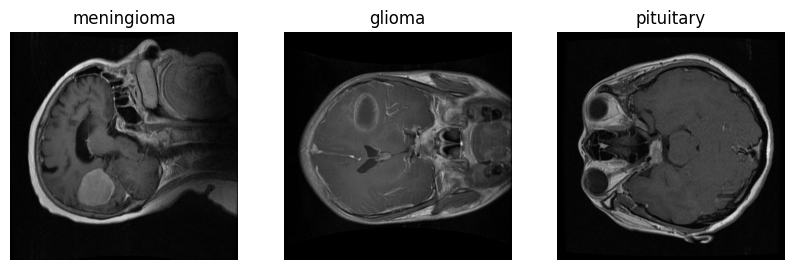

In [9]:
# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 1
columns = 3

img1 = image.load_img(meningioma[0])
img2 = image.load_img(glioma[0])
img3 = image.load_img(pituitary[0])

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(img1)
plt.axis('off')
plt.title("meningioma")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(img2)
plt.axis('off')
plt.title("glioma")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(img3)
plt.axis('off')
plt.title("pituitary")
print("Sample of data")

## 2. Feature extraction

The working mechanism of the HOG algorithm can be summarized as follows
1. Divide the image into cells
2. Calculate the horizontal and vertical gradients for each cell
3. Calculate the magnitude and direction of gradients
4. Generate a histogram vector for each cell
5. Normalization of blocks composed of a set of cell histograms
6. Feature vector formation

To apply HOG, a function from the image processing and computer vision library scikit-image is used. Depending on the mechanism of the previously summarized algorithm, there is a need to adjust four main parameters, which are as follows:



*  Orientations: Number of orientation bins.This parameter controls the length of the histogram vector formed for a cell. The value 9 is usually chosen, which corresponds to the range of angles from 0 to 180 with a step of 20 degrees.
*  Pixels per cell: Cell size in pixels.Cell size plays a very important factor in the size and quality of the resulting features. Choosing a very small cell size will provide a large number of features, which will lead to an increase in the computational cost. In addition, the small cell size makes the resulting features more susceptible to noise in the images. On the contrary, choosing a cell size that is too large will result in producing insufficient information that cannot accurately represent the shapes in the images.
*  Cells per block: Number of cells in each block. To make the resulting features independent of lighting variations, normalization is performed on the histogram vectors. This process can be more useful if the normalization process is performed for a group of cell histograms called a block. However, using this method so that the block is in the form of a sliding window will lead to a significant increase in number of features.
*  Block norm: Block normalization method, which can be L1-norm, L2-norm, L1-sqrt or L2-Hys.



The following code block shows setting the cell size parameter for different values. We notice that as the cell size increases, the number of features decreases significantly, but the features fail to represent the tumor area, while in the case of a very small cell size, the tumor area is clearly represented, but at the expense of increasing dimensions. The cell size was chosen to be (5, 5) to ensure a balance between the dimensions of the features and their effectiveness.

Applaying HOG for different cell sizes


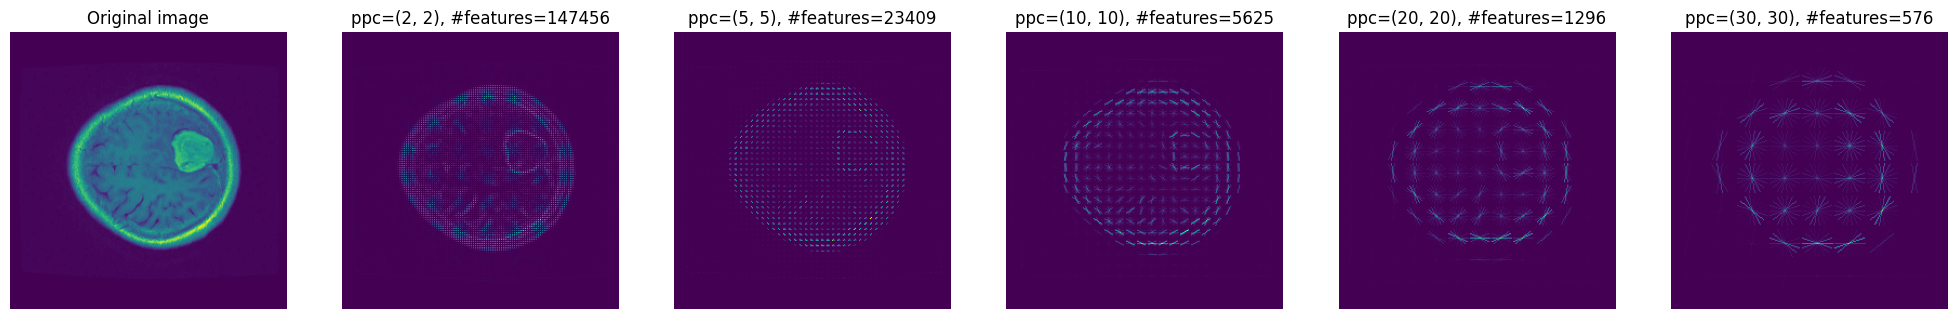

In [10]:
# create figure
fig = plt.figure(figsize=(25, 7))

# setting values to rows and column variables
rows = 1
columns = 6
img = image.load_img(meningioma[21],color_mode='grayscale', target_size=(256, 256))

fd1, hog_image1= hog(img, orientations=9, pixels_per_cell=(2, 2), cells_per_block=(1,1), block_norm='L2', visualize=True)
fd2, hog_image2= hog(img, orientations=9, pixels_per_cell=(5, 5), cells_per_block=(1,1), block_norm='L2', visualize=True)
fd3, hog_image3= hog(img, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(1,1), block_norm='L2', visualize=True)
fd4, hog_image4= hog(img, orientations=9, pixels_per_cell=(20, 20), cells_per_block=(1,1), block_norm='L2', visualize=True)
fd5, hog_image5= hog(img, orientations=9, pixels_per_cell=(30, 30), cells_per_block=(1,1), block_norm='L2', visualize=True)

fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(hog_image1)
plt.axis('off')
plt.title("ppc=(2, 2), #features="+ str(fd1.shape[0]))

fig.add_subplot(rows, columns, 3)
plt.imshow(hog_image2)
plt.axis('off')
plt.title("ppc=(5, 5), #features="+ str(fd2.shape[0]))

fig.add_subplot(rows, columns, 4)
plt.imshow(hog_image3)
plt.axis('off')
plt.title("ppc=(10, 10), #features="+ str(fd3.shape[0]))

fig.add_subplot(rows, columns, 5)
plt.imshow(hog_image4)
plt.axis('off')
plt.title("ppc=(20, 20), #features="+ str(fd4.shape[0]))

fig.add_subplot(rows, columns, 6)
plt.imshow(hog_image5)
plt.axis('off')
plt.title("ppc=(30, 30), #features="+ str(fd5.shape[0]))
print('Applaying HOG for different cell sizes')

The following code block shows the effect of changing the block size while remaining the rest of the parameters constant. It can be seen that with a small increase in the block size, there will be a jump in the number of features. We choose the block size to represent only one cell (1, 1).

In [11]:
fd1, hog_image1= hog(img, orientations=9, pixels_per_cell=(5, 5), cells_per_block=(1,1), block_norm='L2', visualize=True)
fd2, hog_image2= hog(img, orientations=9, pixels_per_cell=(5, 5), cells_per_block=(2,2), block_norm='L2', visualize=True)
fd3, hog_image3= hog(img, orientations=9, pixels_per_cell=(5, 5), cells_per_block=(3,3), block_norm='L2', visualize=True)

print("Number of features for block size (1, 1):"+ str(fd1.shape[0]))
print("Number of features for block size (2, 2):"+ str(fd2.shape[0]))
print("Number of features for block size (3, 3):"+ str(fd3.shape[0]))

Number of features for block size (1, 1):23409
Number of features for block size (2, 2):90000
Number of features for block size (3, 3):194481


Based on the previous discussion, the set of parameters is experimentally selected as follows: [orientations=9, pixels_per_cell=(5, 5), cells_per_block=(1,1), block_norm='L2']

Now we perform the task of extracting HOG features from the entire dataset.

In [12]:
def get_features(img_path):

    '''
    Parameters
    img_path : Path to the image from which features are to be extracted.
    -----------------------------------------------------------------------------
    Output
    numerical_features : numerical representation of the image.

    '''
    # Read the image from the path
    # By default, the load_img function converts the original grayscale image to a color image by assigning the value of each pixel in the grayscale image to each color channel in the color image.\
    # So we confirm that we want the image to remain in its original grayscale form, and then the image is resized to the specified dimensions.
    img = image.load_img(img_path,color_mode='grayscale', target_size=(256, 256))

    # HOG feature extraction
    fd= hog(img, orientations=9, pixels_per_cell=(5, 5), cells_per_block=(1, 1), block_norm='L2', visualize=False)

    # Return the extracted features as numpy array
    return np.reshape(fd, (1,fd.shape[0]))


In [13]:
# Number of features per image
n= 23409

In [14]:
# featuresv saves the features extracted from images
# labels stores the class label of each image
featuresv = []
labels = []

Start features extraxting

In [15]:
# Iterate through the elements in the glioma image directory to extract features and labels
i=0
for image_path in glioma:

    if i  == 0:
      featuresv = np.reshape(get_features(image_path), (1, n))
    else:
      featuresv = np.append(featuresv,np.reshape(get_features(image_path), (1, n)), axis=0)

    labels.append('glioma')
    i+=1

In [16]:
# Iterate through the elements in the meningioma image directory to extract features and labels
for image_path in meningioma:

    featuresv = np.append(featuresv,np.reshape(get_features(image_path), (1, n)), axis=0)

    labels.append('meningioma')

In [17]:
# Iterate through the elements in the pituitary image directory to extract features and labels
for image_path in pituitary:

    featuresv = np.append(featuresv,np.reshape(get_features(image_path), (1, n)), axis=0)

    labels.append('pituitary')

In [18]:
# Print the dimensions of the features matrix
print(featuresv.shape)

(3064, 23409)


In [19]:
# Print the length of the target matrix
print(len(labels))

3064


## 3. Feature optimization

HOG features can contain unhelpful redundancy, which increases the computational cost, especially when deploying the model. To get rid of these features, we will apply an optimization process using the impurity-based feature importance measure within the random forest algorithm. The steps of this method are summarized as follows:


*  A forest of decision trees is fitted to the numerical training samples.
*  Each tree evaluates the importance of the resulting features separately using the impurity measure.
*  The final importance of each feature is calculated as an average of the values ​​resulting from each tree.
*  Features with an importance value less than a specified threshold are eliminated.



In [20]:
featuresf = featuresv
labelsf = labels

In [21]:
# Converting the target variable from categorical form to numerical
labelsf = [int(0) if x=='meningioma' else x for x in labelsf]
labelsf= [int(1) if x=='glioma' else x for x in labelsf]
labelsf= [int(2) if x=='pituitary' else x for x in labelsf]

In [22]:
# Fixing the value of the random generator to ensure the possibility of reproducing the output
random_state=42
# Allocate 20% of the data for testing and the rest for training
test_size=0.2
# Shuffle the data before spliting
shuffle=True

# Split the dayaset into train and test subsets
X_train, X_test,  y_train, y_test = train_test_split(featuresf, labelsf,  random_state=random_state,   test_size=test_size,   shuffle=shuffle)

In the following code block, the random forest algorithm is trained for the purpose of using it to select the set of important features later. It can be seen that three parameters were mainly set in addition to random_state, which are as follows:


*  Number of estimators: The number of trees in the forest. The default setting for this parameter in sikit-learn is 100. Increasing the number of cooperating estimators may improve accuracy if the algorithm is used as a classifier. Although increasing the number of trees does not cause overfitting, it increases the computational cost significantly.
*  Max depth: The maximum depth of the tree. Increasing the depth of the tree to a large value (all leaf nodes are pure) will increase the computational cost and may lead to overfitting, while choosing a value that is too small may not achieve the required accuracy.
*  Bootstrap: Whether bootstrap samples are used when building trees. If the value is False, the entire training data set will be used to build each tree, but it is important to know that this does not mean building identical trees as features are sampled when searching for the best split at each node.


The parameters are set to achieve high performance and balance according to the previous discussion. A random forest of twenty estimators with a maximum depth of ten layers was used, and training was carried out without bootstrapping

In [23]:
# Adjusting the Random Forest parameters used for features optimization

n_estimators=20
max_depth=10
bootstrap=False

# Fixing the value of the random generator to ensure the possibility of reproducing the output
random_state=42

# Create an instance of the Random Forest class, and set its parameters
rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state)

# Fit the Random Forest model according to the given training data
rf = rf.fit(X_train, y_train)

The following code block (written as comments) shows tree No. 1 of the random forest (a screenshot is displayed for a group of leaf nodes). We notice that according to the chosen setting, and in contrast to the default setting, many branches were prevented from reaching the state of pure nodes as a form of regularization. However, the forest is not used as a classifier, but only to evaluate the importance of features using the impurity measure based on the training data.

In [24]:
#dot_data = tree.export_graphviz(rf.estimators_[1], out_file=None, class_names=['meningioma', 'glioma', 'pituitary'], filled=True)
#graph = graphviz.Source(dot_data, format="png")
#graph

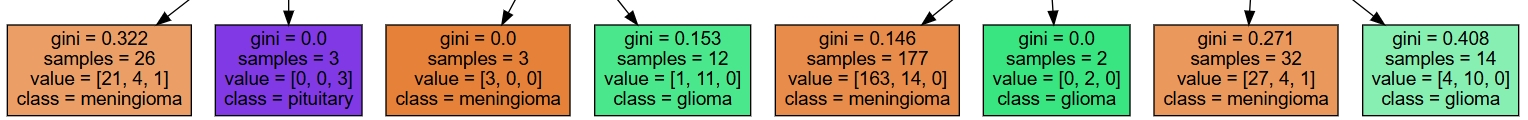

Using the following instructions, it can be seen that the random forest has performed the task of determining the importance of each feature, and it is also shown that the sum of the values ​​of these importances is equal to 1 (due to normalization). However, the process of selecting effective features must also be carried out based on calculated importances.

In [25]:
print("The length of tthe importances vector: ", rf.feature_importances_.shape[0])
print("The sum of the values of the importances vector: ", np.sum(rf.feature_importances_ ))

The length of tthe importances vector:  23409
The sum of the values of the importances vector:  1.0


To choose the effective set of features based on the calculated importances, we use an object of the class SelectFromModel, which is a meta-transformer for selecting features based on a specific model, which in our case is the Random Forest (more precisely, it is the impurity-based feature importances calculated through the Random Forest).

The most important parameter to consider is how to choose the threshold to determine important features from neglected ones. Here we choose the average values ​​of the feature importance vector as the threshold. Features are ignored if their importance value is less than the threshold.

In [26]:
# Selecting the threshold value
threshold = np.mean(rf.feature_importances_)

# Settting the prefit parameter to True means that the model used has already been fitted to the data
prefit=True

model = SelectFromModel(rf, threshold=threshold, prefit=prefit)

# Reduce X_train to the selected features
X_train_transform = model.transform(X_train)

# Reduce X_test to the selected features
X_test_transform = model.transform(X_test)

In [27]:
print("The number of features resulting from the optimization process: ", X_train_transform.shape[1])

The number of features resulting from the optimization process:  3071


## 4. Classificarion and evaluation

Support vector classifier (Linear kernal)

In [28]:
svm = SVC(kernel='linear', C=10, random_state=42)
svm.fit(X_train_transform, y_train)
y_predict_svm = svm.predict(X_test_transform)
accuracy_svm = round(accuracy_score(y_test, y_predict_svm)*100, 2)

In [29]:
# Display the classificarion report
print(classification_report(y_test, y_predict_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8440    0.8322    0.8380       143
           1     0.9218    0.9249    0.9233       293
           2     0.9663    0.9718    0.9690       177

    accuracy                         0.9168       613
   macro avg     0.9107    0.9096    0.9101       613
weighted avg     0.9165    0.9168    0.9166       613



Support vector classifier (RBF kernal)

In [30]:
svm_rbf = SVC(kernel='rbf', C=10, random_state=42)
svm_rbf.fit(X_train_transform, y_train)
y_predict_svm_rbf = svm_rbf.predict(X_test_transform)
accuracy_svm_rbf = round(accuracy_score(y_test, y_predict_svm_rbf)*100, 2)

In [31]:
# Display the classificarion report
print(classification_report(y_test, y_predict_svm_rbf,digits=4))

              precision    recall  f1-score   support

           0     0.8609    0.9091    0.8844       143
           1     0.9647    0.9317    0.9479       293
           2     0.9665    0.9774    0.9719       177

    accuracy                         0.9396       613
   macro avg     0.9307    0.9394    0.9347       613
weighted avg     0.9410    0.9396    0.9400       613



k-nearest neighbors (Fine KNN)

In [32]:
fine_knn = KNeighborsClassifier(n_neighbors=1)
fine_knn.fit(X_train_transform, y_train)
y_predict_fine_knn = fine_knn.predict(X_test_transform)
accuracy_fine_knn = round(accuracy_score(y_test, y_predict_fine_knn)*100, 2)

In [33]:
# Display the classificarion report
print(classification_report(y_test, y_predict_fine_knn,digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9720    0.9858       143
           1     0.9865    1.0000    0.9932       293
           2     1.0000    1.0000    1.0000       177

    accuracy                         0.9935       613
   macro avg     0.9955    0.9907    0.9930       613
weighted avg     0.9936    0.9935    0.9935       613



k-nearest neighbors (k=3)

In [34]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train_transform, y_train)
y_predict_knn3 = knn3.predict(X_test_transform)
accuracy_knn3 = round(accuracy_score(y_test, y_predict_knn3)*100, 2)

In [35]:
# Display the classificarion report
print(classification_report(y_test, y_predict_knn3,digits=4))

              precision    recall  f1-score   support

           0     0.9640    0.9371    0.9504       143
           1     0.9796    0.9829    0.9813       293
           2     0.9833    1.0000    0.9916       177

    accuracy                         0.9772       613
   macro avg     0.9757    0.9733    0.9744       613
weighted avg     0.9770    0.9772    0.9770       613



Logistic Regression

In [36]:
lr = LogisticRegression(max_iter=1000, C=10, random_state=42)
lr.fit(X_train_transform, y_train)
y_predict_lr = lr.predict(X_test_transform)
accuracy_lr = round(accuracy_score(y_test, y_predict_lr)*100, 2)

In [37]:
# Display the classificarion report
print(classification_report(y_test, y_predict_lr,digits=4))

              precision    recall  f1-score   support

           0     0.8521    0.8462    0.8491       143
           1     0.9310    0.9215    0.9262       293
           2     0.9503    0.9718    0.9609       177

    accuracy                         0.9184       613
   macro avg     0.9111    0.9131    0.9121       613
weighted avg     0.9182    0.9184    0.9183       613



Comparison of classification performance for different models

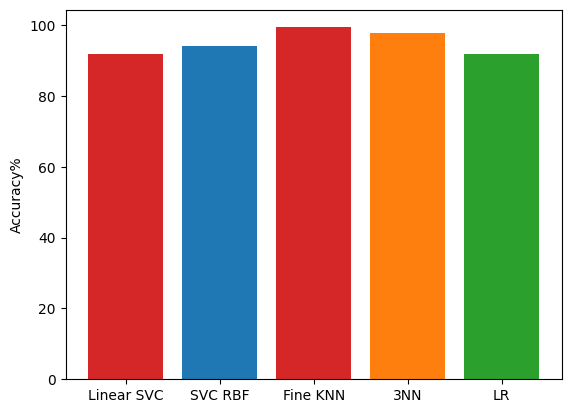

In [38]:
fig, ax = plt.subplots()

fruits = ['Linear SVC', 'SVC RBF', 'Fine KNN', '3NN', 'LR']
counts = [accuracy_svm, accuracy_svm_rbf, accuracy_fine_knn, accuracy_knn3, accuracy_lr]
#bar_labels = ['Linear SVC', 'SVC RBF', 'Fine KNN', '3NN', 'Logistic Regression']
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange', 'tab:green' ]

ax.bar(fruits, counts, color=bar_colors)

ax.set_ylabel('Accuracy%')
#ax.set_title('')

plt.show()

Display the confusion matrix of the best performing model (Fine KNN)

In [39]:
# Third party function for a fancy drawing of the confusion matrix.

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==20:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                precision,recall,f1_score)
        else:
            #stats_text = "\n\nAccuracy={:0.4f}".format(accuracy)
            pass
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)
sns.set_context('talk')

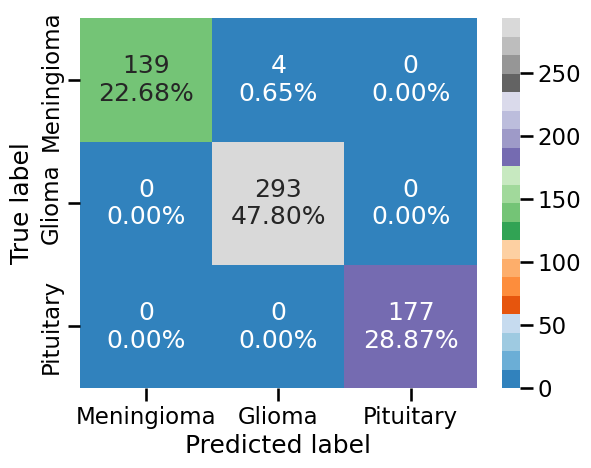

In [40]:
# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict_fine_knn)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma', 'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='tab20c')

In [43]:
# Measuring the average inference time for 30 random samples from all classes

random_sample = []

random_sample.extend(random.sample(meningioma, 10))
random_sample.extend(random.sample(glioma, 10))
random_sample.extend(random.sample(pituitary, 10))

start_time = time.time()
for i in random_sample:
  fine_knn.predict(model.transform([get_features(i)[0]]))
print('Average inference time : ', ((time.time() - start_time) / 30), ' S')

Average inference time :  0.0748611291249593  S
